In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

40
[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


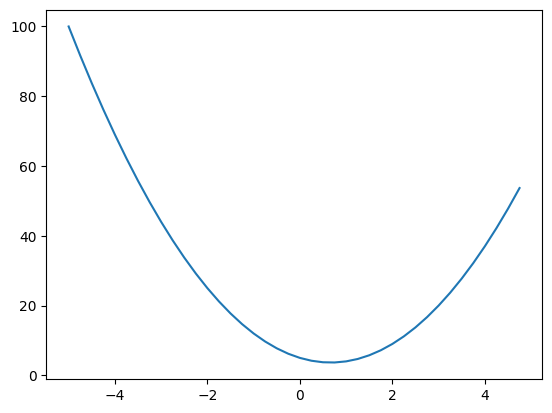

In [5]:
xs = np.arange(-5, 5, 0.25)
print(len(xs))
print(xs)
ys = f(xs)
print(ys)

plt.plot(xs, ys)

In [6]:
h = 0.00000001
x = 2/3
print(f(x))
print(f(x + h))
print((f(x + h) - f(x))/h)

3.666666666666667
3.666666666666667
0.0


In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print(f"d1: {d1}")
print(f"d2: {d2}")
print(f"slope: {(d2 - d1)/h}")

d1: 4.0
d2: 3.999699999999999
slope: -3.000000000010772


In [9]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (float, int))
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other - 1) *  out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1)/(math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [10]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [14]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f } | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2, in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

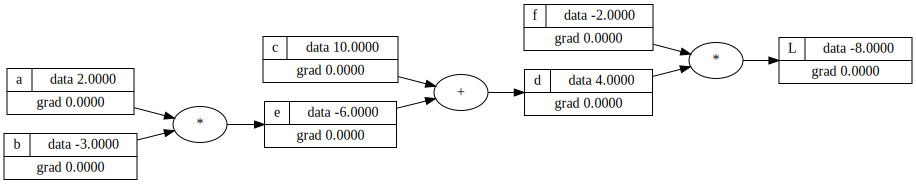

In [15]:
draw_dot(L)

In [16]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [17]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f
print(L.data)

-35.549696


In [18]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0 , label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)

lol()

0.0


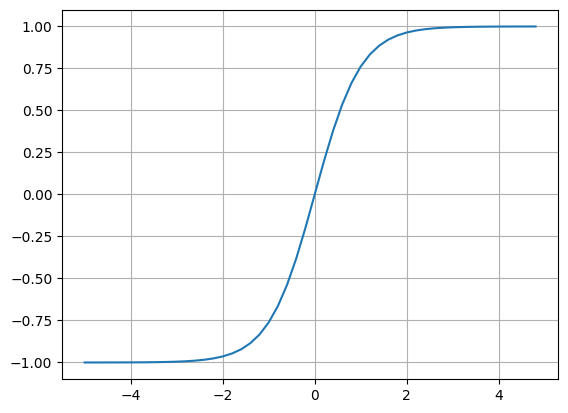

In [19]:
#Activation functions are like squashing functions
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [20]:
#Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2  = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

In [21]:
#Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2  = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1)
o.backward()

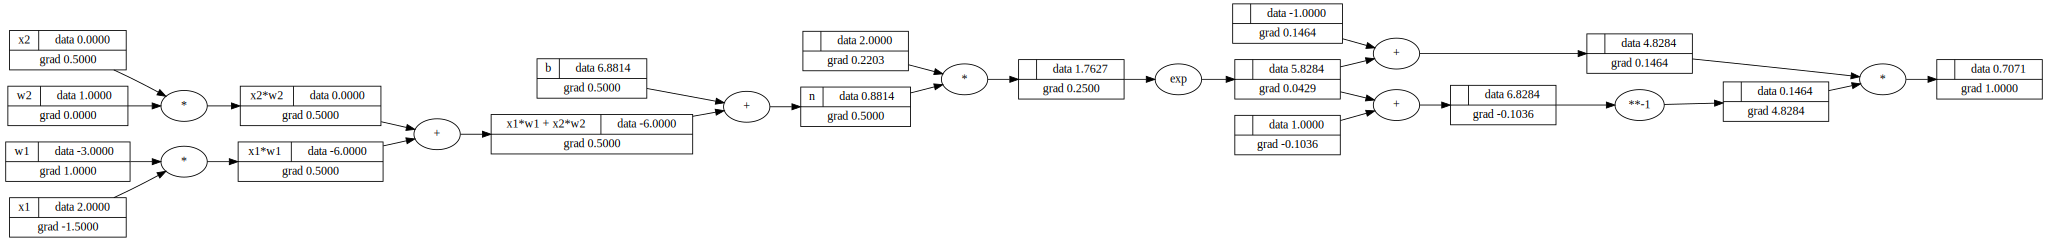

In [22]:
draw_dot(o)

In [23]:
o.backward()

In [24]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-1),
 Value(data=2),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=4.828427124746192),
 Value(data=1),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=0.7071067811865477)]

In [25]:
o.grad = 1.0

for node in reversed(topo):
    node._backward()

In [26]:
o.grad = 1.0

In [27]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [28]:
o.grad = 1.0
# o = tanh(n)
# do/dn = 1 - o^2
n.grad = 1 - o.data**2
#n = x1w1 + x2w2 + b
# do/dx1w1 = do/dn * dn/dx1w1 + x2w2
x1w1x2w2.grad = n.grad * 1
#do/db = do/dn * dn/db
b.grad = n.grad * 1
#do/dx2w2 = dx1w1+x2w2/dx2w2 + dn/dx1w1+x2w2 + do/dn
x2w2.grad = 1 * x1w1x2w2.grad
x1w1.grad = 1 * x1w1x2w2.grad
#do/dx2 = do/dn * dn/dx1w1+x2w2 * dx1w1+x2w2/dx2w2 * dx2w2/dx2
x2.grad = w2.data * x2w2.grad
#do/dw2 = do/dn * dn/dx1w1+x2w2 * dx1w1+x2w2/dx2w2 * dx2w2/dw2
w2.grad = x2.data * x2w2.grad
#do/dx1 = do/dn * dn/dx1w1*x2w2 * dx1w1*x2w2/dx1w1 * dx1w1/dx1
x1.grad = w1.data * x1w1.grad
#do/dw1 = do/dn * dn/dx1w1*x2w2 * dx1w1*x2w2/dx1w1 * dx1w1/dw1
w1.grad = x1.data * x1w1.grad

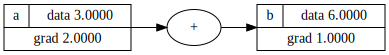

In [29]:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

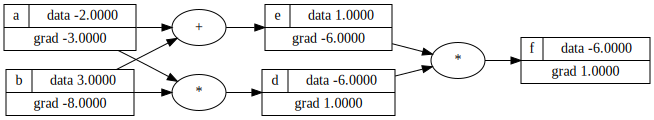

In [30]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'
f.backward()
draw_dot(f)

In [34]:
import torch

x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---------------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [84]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act =  sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [222]:

x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6335579020559834)

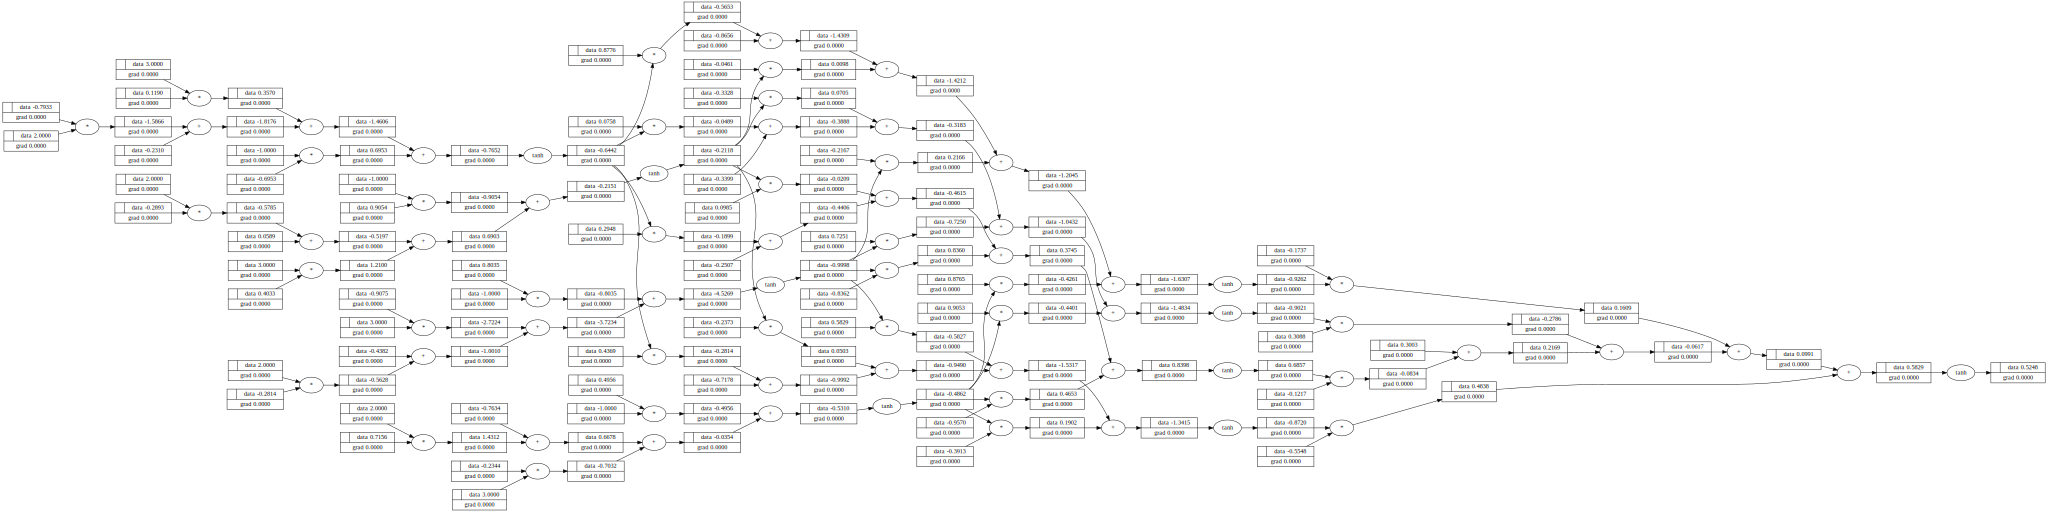

In [62]:
draw_dot(n(x))

In [223]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

In [95]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print(loss)
loss.backward()


Value(data=5.466259318169057)


In [96]:
n.layers[0].neurons[0].w[0].grad
n.layers[0].neurons[0].w[0].data

0.28581645181511894

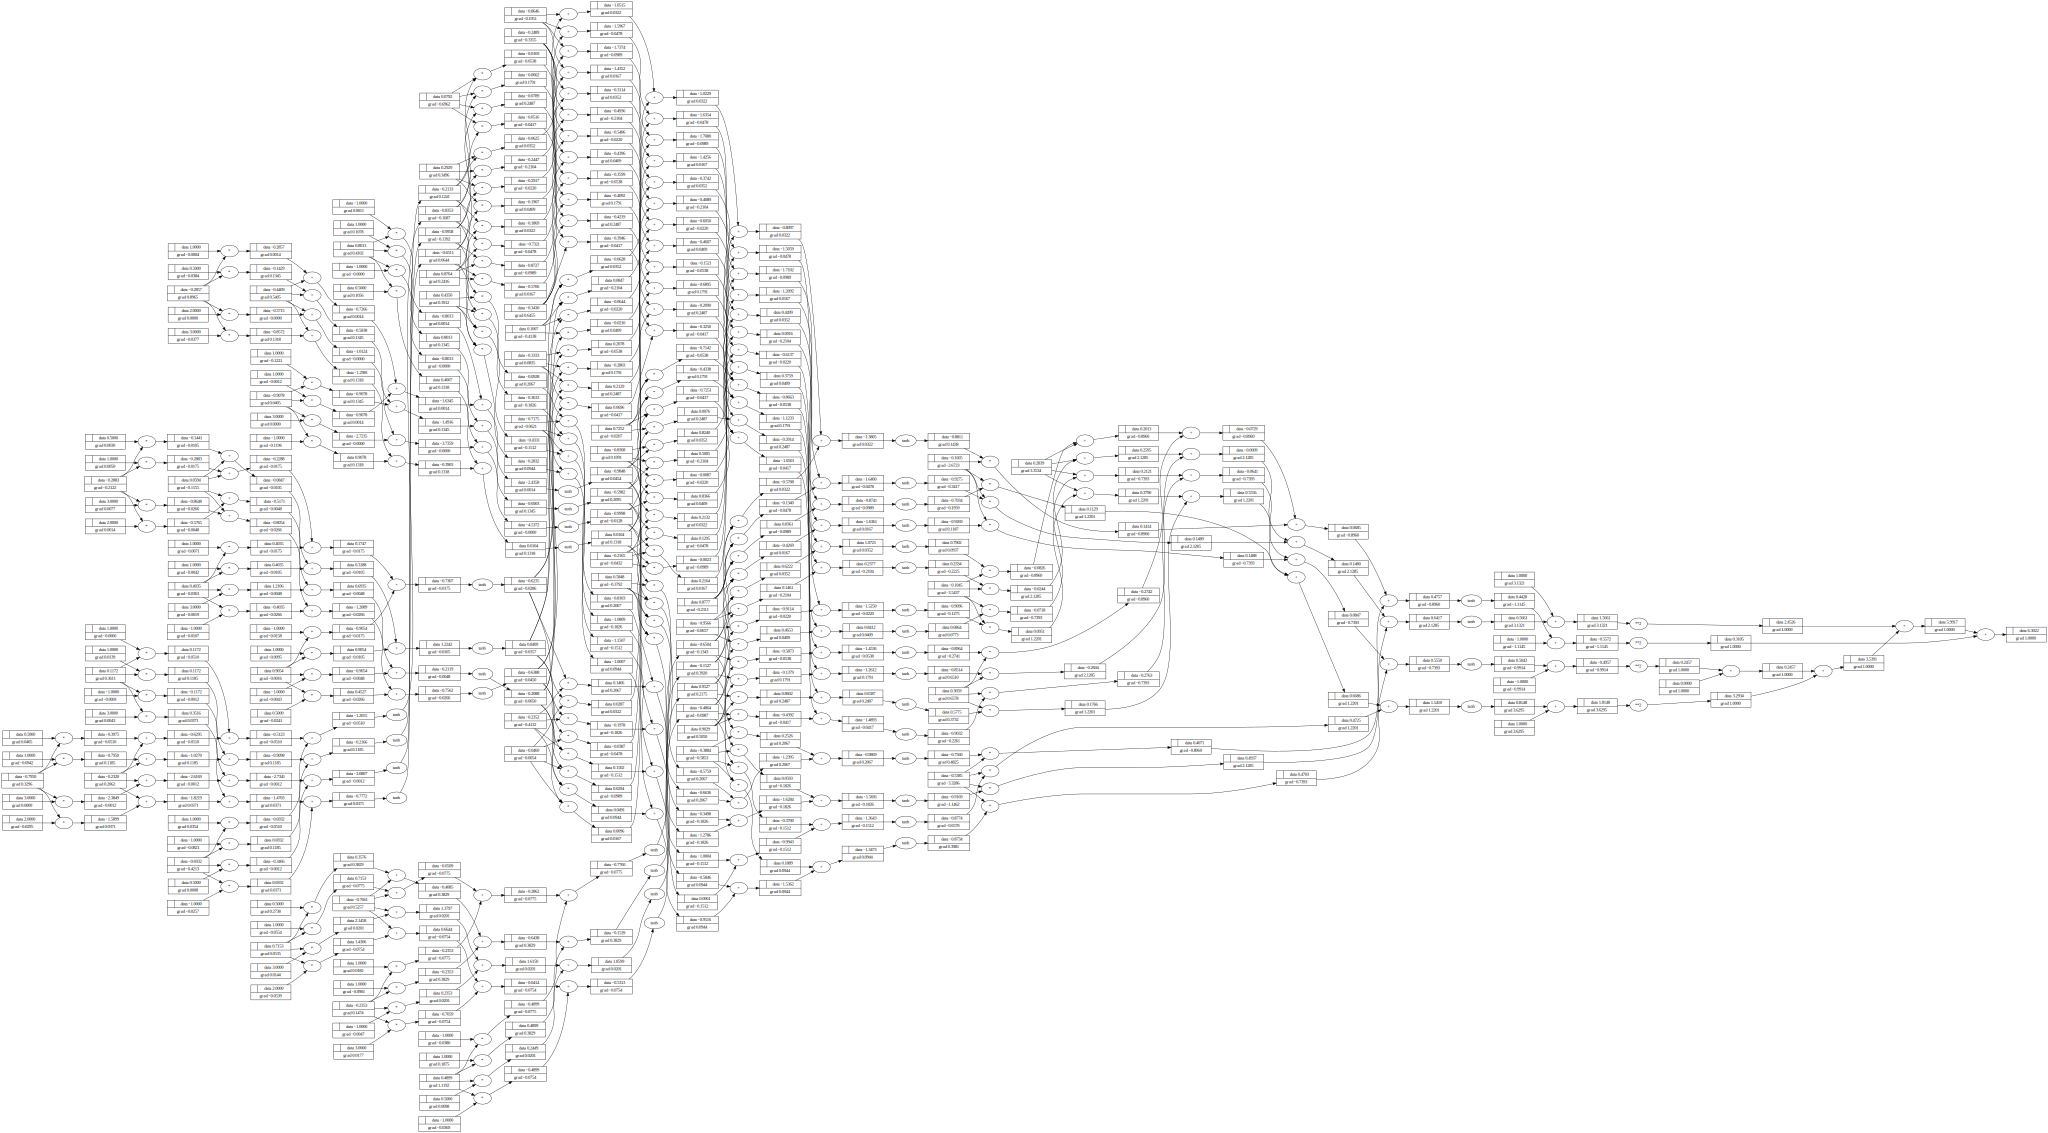

In [78]:
draw_dot(loss)

In [97]:
n.parameters()

[Value(data=0.28581645181511894),
 Value(data=0.042202654053473454),
 Value(data=-0.7872028407711957),
 Value(data=-0.6394649921270865),
 Value(data=-0.8943350163067298),
 Value(data=-0.7054710092134937),
 Value(data=-0.05461008336599993),
 Value(data=-0.27358652876148737),
 Value(data=0.3388311471749077),
 Value(data=0.10442100271135613),
 Value(data=-0.3137253154093873),
 Value(data=0.6394452915994742),
 Value(data=0.23809081596462733),
 Value(data=0.134488603954378),
 Value(data=0.06511484709609694),
 Value(data=-0.5686603012132065),
 Value(data=0.6378642393545506),
 Value(data=0.4226235324314018),
 Value(data=-0.6469883764639381),
 Value(data=-0.9899943038459451),
 Value(data=0.39113536895189593),
 Value(data=0.9712573020144502),
 Value(data=-0.15375113749891467),
 Value(data=0.47512390827648576),
 Value(data=-0.2629274835841313),
 Value(data=0.4062590030575899),
 Value(data=0.5225685878004809),
 Value(data=-0.44084451550573744),
 Value(data=-0.34081055665259763),
 Value(data=-0.89

In [98]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [99]:
n.layers[0].neurons[0].w[0].data

0.3141468697014953

In [ ]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) #Mean Squared Error Loss
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.0005324579769880143
1 0.0005320662598621041
2 0.0005316751023707353
3 0.0005312845033321007
4 0.0005308944615676907
5 0.0005305049759022804
6 0.0005301160451639236
7 0.0005297276681839116
8 0.0005293398437968137
9 0.0005289525708404433
10 0.0005285658481558127
11 0.0005281796745871842
12 0.0005277940489819917
13 0.0005274089701909031
14 0.0005270244370677358
15 0.0005266404484695113
16 0.0005262570032563863
17 0.0005258741002916878
18 0.0005254917384418632
19 0.0005251099165765242


In [303]:
ypred

[Value(data=0.9902145301100092),
 Value(data=-0.9882238728232117),
 Value(data=-0.9882234881218334),
 Value(data=0.9876715332539641)]